In [1]:
# Import all essential libraries

import os
import csv
import ipdb
import math
import warnings
import random
import numpy as np
import networkx as nx
import scipy.constants as sc
import matplotlib.pyplot as plt
import networkx.algorithms.isomorphism as iso

In [2]:
class Compound():
    def __init__(self, name, number):
        self._name = name + " " + str(number)
        self._number = number
        self._valency = self.get_max_valency()

    def get_max_valency(self):
        name = self._name.split()[0]
        if name == "H":
            return 1
        elif name == "C":
            return 4
        elif name == "N":
            return 3
        elif name == "O":
            return 2
        elif name == "S":
            return 2

    def current_valency(self, G):
        neig = nx.degree(G, self)
        max_val = self.get_max_valency()
        if neig > max_val:
            raise ValueError('Compound has more neighbours than valence')
        else:
            # print(max_val, neig)
            self._valency = max_val - neig
        
    def get_total_valency(self, G):
        neig = nx.degree(G, self)
        free_electrons = self.get_max_valency() - neig
        return free_electrons
        
        
    def __repr__(self):
        return self._name

In [3]:
def plot_fig(G):
    A = nx.adjacency_matrix(G)
    pos = nx.spring_layout(G)
    nodes = list(nx.nodes(G))
    mapping = {}
    for i,j in enumerate(nodes):
        mapping[j] = i
        
    plt.figure()
    for i in G.edges():
        G[i[0]][i[1]][0]['number'] = A[mapping[i[0]], mapping[i[1]]]
    labels = nx.get_edge_attributes(G, 'number')
    edge_labels = {}
    for i in labels:
        edge_labels[(i[0], i[1])] = labels[i]
    nx.draw(G, pos, with_labels=True,edge_color='black',width=1,linewidths=1,node_size = 500,node_color='pink',alpha=0.9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
    plt.axis('off')
    plt.show()

In [4]:
# Defining the atom list in the Graph

H_list = [Compound("H", i) for i in range(1,33)]
C_list = [Compound("C", i) for i in range(33, 41)]
O_list = [Compound("O", i) for i in range(41, 49)]
N_list = [Compound("N", i) for i in range(49, 57)]

complete_list = [];
for lst in [H_list, C_list, O_list, N_list]:
    complete_list.extend(lst)

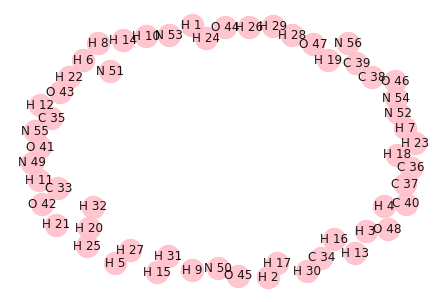

In [5]:
# Creating the graph with just atoms
# MultiGraph is being used for ease of representing
# double and possible triple bonds
# Here, 
#    - lst loops through the lists (H, C, O and N)
#    - comp loops over the compounds

G = nx.MultiGraph()
for i,lst in enumerate([H_list, C_list, O_list, N_list]):
    for comp in lst:
        G.add_node(comp, data=comp)
plot_fig(G)

In [6]:
nx.nodes(G)

NodeView((H 1, H 2, H 3, H 4, H 5, H 6, H 7, H 8, H 9, H 10, H 11, H 12, H 13, H 14, H 15, H 16, H 17, H 18, H 19, H 20, H 21, H 22, H 23, H 24, H 25, H 26, H 27, H 28, H 29, H 30, H 31, H 32, C 33, C 34, C 35, C 36, C 37, C 38, C 39, C 40, O 41, O 42, O 43, O 44, O 45, O 46, O 47, O 48, N 49, N 50, N 51, N 52, N 53, N 54, N 55, N 56))

In [7]:
# Function to update the valencies of the atoms
# This function updates the atom valencies based 
# on the number of edges that atom forms.

def fix_valencies(G):
    for node in nx.nodes(G):
        degree = len(G[node])
        if degree > 0:
            node.current_valency(G)

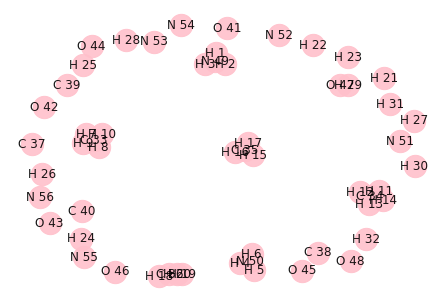

In [8]:
# Adding all the nodes

G.add_edges_from([(H_list[0], N_list[0]), (N_list[0], H_list[1]), (N_list[0], H_list[2])])
G.add_edges_from([(H_list[3], N_list[1]), (N_list[1], H_list[4]), (N_list[1], H_list[5])])

G.add_edges_from([(H_list[6], C_list[0]), (H_list[7], C_list[0]), (H_list[8], C_list[0]), (H_list[9], C_list[0])])
G.add_edges_from([(H_list[10], C_list[1]), (H_list[11], C_list[1]), (H_list[12], C_list[1]), (H_list[13], C_list[1])])

#Added CH3, CH2 and OH to test bond formations. Can be erased later.
G.add_edges_from([(H_list[14], C_list[2]), (H_list[15], C_list[2]), (H_list[16], C_list[2])])
G.add_edges_from([(H_list[17], C_list[3]), (H_list[18], C_list[3])])
G.add_edge(O_list[6], H_list[28])

fix_valencies(G)
plot_fig(G)

In [9]:
nx.nodes(G)

NodeView((H 1, H 2, H 3, H 4, H 5, H 6, H 7, H 8, H 9, H 10, H 11, H 12, H 13, H 14, H 15, H 16, H 17, H 18, H 19, H 20, H 21, H 22, H 23, H 24, H 25, H 26, H 27, H 28, H 29, H 30, H 31, H 32, C 33, C 34, C 35, C 36, C 37, C 38, C 39, C 40, O 41, O 42, O 43, O 44, O 45, O 46, O 47, O 48, N 49, N 50, N 51, N 52, N 53, N 54, N 55, N 56))

In [10]:
# Function to calculate H

def calculate_H(data, T):
    [a_2, a_1, a0, a1, a2, a3, a4, a5, _] = data

    H = sc.R*T*(-a_2*T**-2 + a_1*T**-1*np.log(T) + a0 + 0.5*a1*T + (a2*T**2)/3 + 0.25*a3*T**3 + 0.2*a4*T**4 +a5*T**-1)
    return H

# Function to calculate S

def calculate_S(data, T):
    [a_2, a_1, a0, a1, a2, a3, a4, _, a6] = data

    S = sc.R*(-0.5*a_2*T**-2 - a_1*T**-1 + a0*np.log(T) + a1*T + 0.5*a2*T**2 + (a3*T**3/3) + 0.25*a4*T**4 + a6)

    return S

# Function to calculate G

def calculate_G(H, S, T):
    G = H - T*S
    return G

In [11]:
# Code to get the H, S and G data for a whole dataset

def get_lib_data(libraries_list, temperature, path):
    # libraries_list = rmg_link_lists()

    H_lists = []
    S_lists = []
    G_lists = []

    H_list = []
    S_list = []
    G_list = []

    for lib in libraries_list:
        os.chdir(path)

        compound_list = os.listdir()        

        directory = f"{lib}_data"
        if os.path.exists(f"{directory}/csv"):
            print("CSV folder exists")
            os.chdir(f"{directory}/csv")
        
            compound_list = os.listdir()

            for file_name in compound_list:
                fin = open(file_name)
                reader = csv.reader(fin)
                data = []
                if (temperature > 100 and temperature < 1074.56):
                    for i in reader:
                        data.append(float(i[0]))
                else:
                    for i in reader:
                        data.append(float(i[1]))

                H = calculate_H(data, temperature)
                S = calculate_S(data, temperature)
                G = calculate_G(S, H, temperature)

                H_list.append(H)
                S_list.append(S)
                G_list.append(G)

            H_lists.append(H_list)
            S_lists.append(S_list)
            G_lists.append(G_list)

    return [H_lists, S_lists, G_lists]

# path = os.getcwd()
# libraries_list = ['primaryThermoLibrary', 'DFT_QCI_thermo', 'GRI-Mech3.0', 'CBS_QB3_1dHR', 'thermo_DFT_CCSDTF12_BAC', 'SABIC_aromatics', 'C3', 'Fulvene_H', 'BurkeH2O2', 'Chlorinated_Hydrocarbons', 'Narayanaswamy', 'CHN', 'surfaceThermoPt', 'vinylCPD_H', 'SulfurGlarborgH2S', 'naphthalene_H', 'NOx2018', 'iodinated_Hydrocarbons', 'JetSurF1.0', 'surfaceThermoNi', 'SulfurGlarborgMarshall', 'CH', 'NitrogenCurran', 'CHO', 'bio_oil', 'SulfurLibrary', 'C10H11', 'Klippenstein_Glarborg2016', 'primaryNS', 'CurranPentane', 'USC-Mech-ii', 'GRI-Mech3.0-N', 'JetSurF2.0', 'FFCM1(-)', 'SulfurGlarborgNS', 'NISTThermoLibrary', 'Lai_Hexylbenzene', 'SulfurHaynes', 'CN', 'BurcatNS', 'SulfurGlarborgBozzelli', 'Chernov', 'CHON']

# [H_lists, S_lists, G_lists] = get_lib_data(libraries_list, 700, path)

# for lib,H_list,S_list,G_list in zip(libraries_list, H_lists, S_lists, G_lists):
#     print(lib)

#     for H, S, G in zip(H_list, S_list, G_list):
#         print("%.2f" %H, end="\t\t")
#         print("%.2f" %S, end="\t\t")
#         print("%.2f" %G)

In [12]:
# Code to calculate the H, S and G values for specific compound
def get_single_compound_data(lib, temperature, path, file_name):
    # Code to calculate the H, S and G values for specific compound
    os.chdir(path) 

    directory = f"{lib}_data"    
    if os.path.exists(f"{directory}/csv"):
        os.chdir(f"{directory}/csv")
        
        fin = open(file_name)
        reader = csv.reader(fin)
        data1 = []
        data2 = []

        for row in reader:
            data1.append(float(row[0]))
            data2.append(float(row[1]))
            
        if (temperature > data1[0] and temperature < data1[1]):
            # print('Choosing from data 1')
            data = data1[2:]
        elif (temperature > data2[0] and temperature < data2[1]):
            # print('Choosing from data 2')
            data = data2[2:]
        else:
            print("The enquired compound doesn't have data for the temperature provided.")

        H = calculate_H(data, temperature)
        S = calculate_S(data, temperature)
        G = calculate_G(H, S, temperature)
        
        os.chdir(path)
        return (H, S, G)
    else:
        print("The file requested is unavailable")

In [13]:
# A test example for calculating G

temperature = 700
path = os.getcwd()

# Details for NH3 (Ammonia)
# https://rmg.mit.edu/database/thermo/molecule/1%20N%20u0%20p1%20c0%20%7B2,S%7D%20%7B3,S%7D%20%7B4,S%7D%0A2%20H%20u0%20p0%20c0%20%7B1,S%7D%0A3%20H%20u0%20p0%20c0%20%7B1,S%7D%0A4%20H%20u0%20p0%20c0%20%7B1,S%7D%0A
ammonia_lib = "NOx2018"
ammonia_file_name = "65.csv"

os.chdir(path)
result = get_single_compound_data(ammonia_lib, temperature, path, ammonia_file_name)
print(result)

(-28703.85868409499, 227.77781807246183, -188148.33133481827)


In [14]:
# Get the list of all components and atoms

atoms = []
compounds = []
all_compounds = nx.connected_components(G)
list_compounds = list(all_compounds)

for i in range(len(list_compounds)):
    if len(list(list_compounds[i])) == 1:
        atoms.append(list(list_compounds[i])[0])
    else:
        compounds.append(list(list_compounds[i]))

In [15]:
free_electrons = []
for i in complete_list:
    val = 0
    compound_contrib = {}
    if np.size(i) > 1:
        for j in i:
            compound_contrib[j] = j.get_total_valency(G)
            val += j.get_total_valency(G)
    else:
        compound_contrib[i] = i.get_total_valency(G)
        val += i.get_total_valency(G)
    free_electrons.append((val, compound_contrib))

In [16]:
maximum_edges = 0; # 52
for lst in [H_list, C_list, O_list, N_list]:
    for atom in lst:
        maximum_edges += atom.get_max_valency()
        
maximum_edges = maximum_edges//2;
print(maximum_edges)

52


In [17]:
# G = generate_random_graphs(G, maximum_edges)
# nx.draw(G, with_labels=True)
# plt.show()
# print(nx.number_of_edges(G))

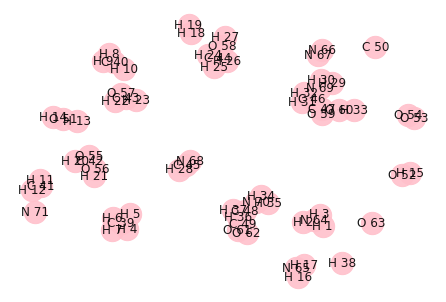

{<networkx.classes.multigraph.MultiGraph object at 0x7f980b8b2a60>: -185940.2151, <networkx.classes.multigraph.MultiGraph object at 0x7f980b8ce130>: -212885.1171, <networkx.classes.multigraph.MultiGraph object at 0x7f980b77fa60>: 2651.927862, <networkx.classes.multigraph.MultiGraph object at 0x7f980b77fe20>: 247769.9191, <networkx.classes.multigraph.MultiGraph object at 0x7f980b77f160>: -380604.1595, <networkx.classes.multigraph.MultiGraph object at 0x7f980b77f0d0>: -2327000, <networkx.classes.multigraph.MultiGraph object at 0x7f980b77f970>: 43528.0415, <networkx.classes.multigraph.MultiGraph object at 0x7f980b77f190>: -97169.28744, <networkx.classes.multigraph.MultiGraph object at 0x7f980b77f820>: -563584.8, <networkx.classes.multigraph.MultiGraph object at 0x7f980b782fd0>: -269522.2798, <networkx.classes.multigraph.MultiGraph object at 0x7f980b782f70>: -379091.4382, <networkx.classes.multigraph.MultiGraph object at 0x7f980b782580>: -16772.10243, <networkx.classes.multigraph.MultiGrap

In [18]:
H = nx.MultiGraph()

H_lists = [Compound("H",i) for i in range(1,39)]
C_lists = [Compound("C",i) for i in range(39, 51)]
O_lists = [Compound("O",i) for i in range(51, 64)]
N_lists = [Compound("N",i) for i in range(64, 72)]
for i,lst in enumerate([H_lists, C_lists, O_lists, N_lists]):
    for comp in lst:
        H.add_node(comp, data=comp)

# nx.draw(H,with_labels=True)
H.add_edges_from([(H_lists[0], N_lists[0]), (N_lists[0], H_lists[1]), (N_lists[0], H_lists[2])])
H.add_edges_from([(H_lists[3], C_lists[0]), (H_lists[4], C_lists[0]), (H_lists[5], C_lists[0]), (H_lists[6], C_lists[0])])
H.add_edges_from([(H_lists[7], C_lists[1]), (H_lists[8], C_lists[1]), (H_lists[9], C_lists[1])])
H.add_edges_from([(H_lists[10], C_lists[2]), (H_lists[11], C_lists[2])])
H.add_edges_from([(H_lists[12], O_lists[0]), (H_lists[13], O_lists[0])])
H.add_edges_from([(H_lists[14], O_lists[1])])
H.add_edges_from([(H_lists[15], N_lists[1]), (N_lists[1], H_lists[16])])
H.add_edges_from([(H_lists[17], H_lists[18])])
H.add_edges_from([(O_lists[2], O_lists[3])])
H.add_edges_from([(N_lists[2], N_lists[3])])
H.add_edges_from([(H_lists[19], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[5], C_lists[3]),(H_lists[20], O_lists[5])])
H.add_edges_from([(H_lists[21], C_lists[4]),(O_lists[6], C_lists[4]),(O_lists[6], C_lists[4]),(H_lists[22], C_lists[4])])
H.add_edges_from([(H_lists[23], C_lists[5]), (H_lists[24], C_lists[5]), (H_lists[25], C_lists[5]),(O_lists[7], C_lists[5]),(O_lists[7], H_lists[26])])
H.add_edges_from([(H_lists[27], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6])])
H.add_edges_from([(H_lists[28], N_lists[5]), (N_lists[5], H_lists[29]), (N_lists[5], C_lists[7]), (H_lists[30], C_lists[7]), (C_lists[7], H_lists[31]), (C_lists[7], C_lists[8]), (O_lists[8], C_lists[8]),(O_lists[8], C_lists[8]),(O_lists[9], C_lists[8]),(H_lists[32], O_lists[9])])
H.add_edges_from([(H_lists[33], N_lists[6]), (N_lists[6], H_lists[34]), (N_lists[6], C_lists[9]), (H_lists[35], C_lists[9]), (C_lists[9], H_lists[36]), (C_lists[9], C_lists[10]), (O_lists[10], C_lists[10]),(O_lists[10], C_lists[10]),(O_lists[11], C_lists[10])])

plot_fig(H)

data_G = {}
G_value = [-185940.2151,-212885.1171,2651.927862,247769.9191,-380604.1595,-2327000,43528.0415,-97169.28744,-563584.8,-269522.2798,-379091.4382,-16772.10243,-664582.9247,-664582.9247,133624.1442,736592.6058,-149516.614,132423.6,-139871.6185,361063.4601]

entities = nx.connected_components(H)
entities = list(entities)
for i in range(len(entities)):
    sub = H.subgraph(list(entities[i]))
#     print(sub.nodes)
    data_G[sub] = G_value[i]
fix_valencies(H)    
print(data_G)

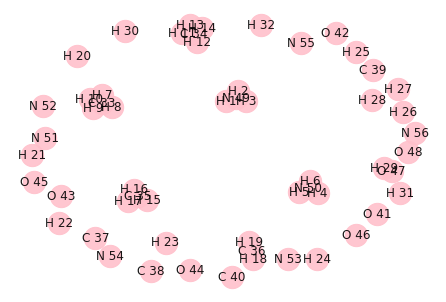

H 1 0
H 2 0
H 3 0
H 4 0
H 5 0
H 6 0
H 7 0
H 8 0
H 9 0
H 10 0
H 11 0
H 12 0
H 13 0
H 14 0
H 15 0
H 16 0
H 17 0
H 18 0
H 19 0
H 20 1
H 21 1
H 22 1
H 23 1
H 24 1
H 25 1
H 26 1
H 27 1
H 28 1
H 29 0
H 30 1
H 31 1
H 32 1
C 33 0
C 34 0
C 35 1
C 36 2
C 37 4
C 38 4
C 39 4
C 40 4
O 41 2
O 42 2
O 43 2
O 44 2
O 45 2
O 46 2
O 47 1
O 48 2
N 49 0
N 50 0
N 51 3
N 52 3
N 53 3
N 54 3
N 55 3
N 56 3


In [19]:
plot_fig(G)
for i in G.nodes:
    i.current_valency(G)
    print(i._name, i._valency)

In [20]:
# Finding G of all components given a network
def input_G(G):
    
    cc = list(nx.connected_components(G))
    G_energy = 0
    
    for i in range(len(cc)):
        found = 0
        
        # print("Connected Component G:", cc[i])
        sub_G = G.subgraph(list(cc[i]))
        same = False
        
        for j in data_G:
            # print(j.nodes)
            GH = iso.GraphMatcher(sub_G,j)
            
            # print("Isomorphic:", GH.is_isomorphic())
            if GH.is_isomorphic() == True:
                same = True
            else:
                same = False
            
            if same == True:
                if len(GH.mapping) != 2:
                    for k in GH.mapping: # check mapping of each nodes
                        # print(str(k)[0])
                        # print(str(GH.mapping[k])[0])
                        if str(k)[0] == str(GH.mapping[k])[0]: # Each node's label (without index) should coincide
                            same = True
                        else:
                            same = False
                            break
                else:
                    keys = []
                    values = []
                    for i in GH.mapping.keys():
                        keys.append(str(i).split()[0])
                    for i in GH.mapping.keys():
                        values.append(str(i).split()[0])
                    keys = keys.sort()
                    values = values.sort()
                    if keys == values:
                        same = True
                    else: 
                        same = False
                        
                # print(same)
                
            if same == True: # If compound is found, add G
                found = 1
                break

        if same == True:
            G_energy += data_G[j]
            
        elif same == False: # If compound not found,
            randomp = G.subgraph(list(cc[i]))
            plot_fig(randomp)
            
            val = float(input('Enter G value of %s: '%list(cc[i])))
            data_G[sub_G] = val # Add the new compound's data to our dictionary
            G_energy += val
            # print(G_energy)
    return G_energy

In [21]:
input_G(G)

4768977.296762

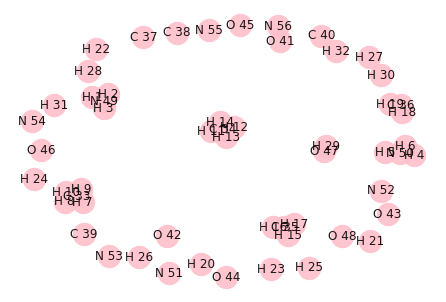

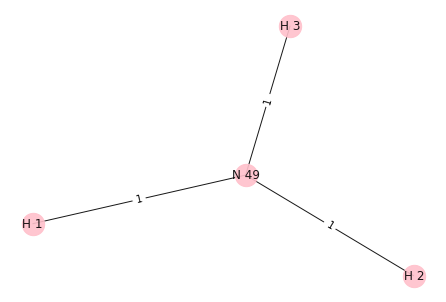

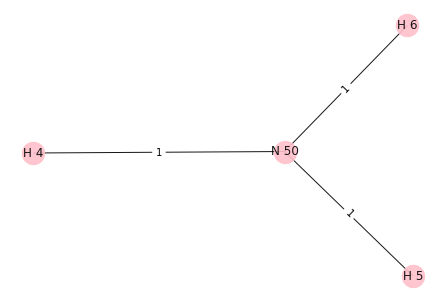

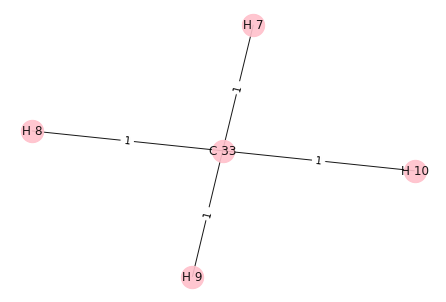

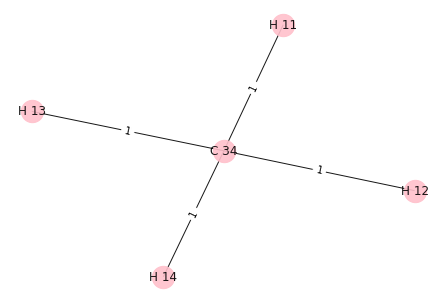

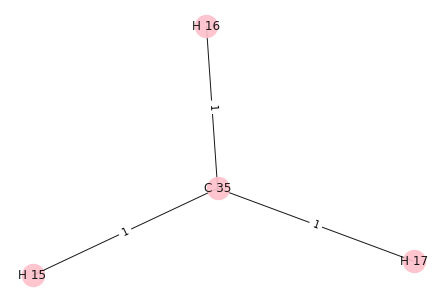

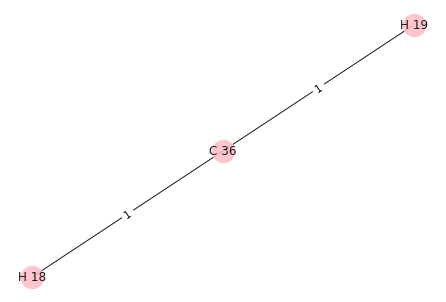

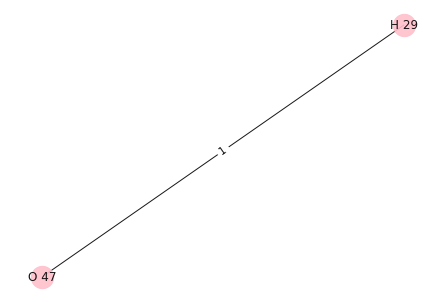

In [22]:
plot_fig(G)
cc = nx.connected_components(G)
for i in cc:
    if len(i) > 1:
        M = G.subgraph(list(i))
        plot_fig(M)

In [23]:
def get_exp_number_bonds(s, max_bonds):
    # Function imitates a Michaelis-Menten curve
    # for the number of bonds allowable at a 
    # given cycle and ceils the value returned.
    bond = math.ceil((max_bonds*s)/(0.5 + s))
    
    return bond

In [26]:
def generate_random_graphs_new(G, max_bonds, probab):
    nodes = list(nx.nodes(G))
    # print("Length:", len(nodes))
    connected_components = nx.connected_components(G)
    for i in connected_components:
        if len(i) > 1:
            plot_fig(G.subgraph(list(i)))
        
    A = nx.adjacency_matrix(G)

    bonds = get_exp_number_bonds(probab, max_bonds)
    # print("Bonds to be formed:", bonds)
    # print("Number of edges:", nx.number_of_edges(G))
    if bonds > max_bonds:
        bonds = 0

    while nx.number_of_edges(G) < bonds:
        # ipdb.set_trace()
        # print("Bonds to be formed:", bonds)
        # print("Number of edges:", nx.number_of_edges(G))
        flag = 0
        initial_net = G
        row = random.randint(0,len(nodes)-1)
        cur_val1 = (nodes[row])._valency
        # ipdb.set_trace()
        while not(cur_val1 >= 1):
            flag = 1
            row = random.randint(0,len(nodes)-1)
            cur_val1 = nodes[row]._valency
        else:
            # print("Node1:", nodes[row]._name)
            # print("Curr val1:", cur_val1)
            col = random.randint(0, len(nodes)-1)
            cur_val2 = nodes[col]._valency
            # print("flag:", flag)
            while (not(cur_val2 >= 1)) or (row==col):
                flag = 2
                col = random.randint(0, len(nodes)-1)
                cur_val2 = nodes[col]._valency
                # print("Random node choosen:", nodes[col]._name)
                if cur_val2 > 0:
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                    # print("Node2:", nodes[col]._name)
                    # print("Curr val2:", cur_val2)
                    # print(nodes[row]._valency, nodes[col]._valency)
                    # print("max_num_edges:", max_num_edges)
                    
                    # for cc in nx.connected_components(G):
                    #     if nodes[row] in cc:
                    #         plot_fig(G.subgraph(list(cc)))
                    #     if nodes[col] in cc:
                    #         plot_fig(G.subgraph(list(cc)))
                            
                    for times in range(max_num_edges):
                        G.add_edge(nodes[row], nodes[col])
            
            # Pruning any self edges
            for i in range(len(nodes)):
                neigh = G[nodes[i]]
                if nodes[i] in neigh:
                    G.remove_edge(nodes[i], nodes[i])
                
            print("flag_end:", flag)
            if flag == 0 and (row!= col):
                # print(nodes[row]._name, nodes[row]._valency)
                # print(nodes[col]._name, nodes[col]._valency)
                if min(nodes[row]._valency, nodes[col]._valency) > 1:
                    max_num_edges = random.randint(1, min(nodes[row]._valency, nodes[col]._valency))
                else: max_num_edges = 1
                # print("max_num_edges:", max_num_edges)
                for times in range(max_num_edges):
                    G.add_edge(nodes[row], nodes[col])
                
                for i in nx.connected_components(G):
                        if len(i)>11:
                            G = initial_net
        bad = 0
        for i in nx.connected_components(G):
            if len(i)>15:
                bad = 1
        if bad != 0:
            G = initial_net
            
        for i in list(nx.nodes(G)):
            if (i==nodes[row]) or (i==nodes[col]): 
                print(i._name, "Previous Valency:", i._valency)
            try:
                i.current_valency(G)
            except ValueError:
                print("ValueException occured !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                print(i._name)
                print(i._valency)
                ipdb.set_trace()
                for cc in nx.connected_components(G):
                    if nodes[row] in cc:
                        plot_fig(G.subgraph(list(cc)))
            if (i==nodes[row]) or (i==nodes[col]): 
                print(i._name, "Current valency:", i._valency)
    return G

flag_end: 0
C 37 Previous Valency: 4
C 37 Current valency: 3
N 52 Previous Valency: 3
N 52 Current valency: 2
flag_end: 2
C 37 Previous Valency: 3
C 37 Current valency: 1
O 45 Previous Valency: 2
O 45 Current valency: 0
flag_end: 0
C 34 Previous Valency: 4
C 34 Current valency: 2
N 49 Previous Valency: 3
N 49 Current valency: 1
flag_end: 1
H 3 Previous Valency: 1
H 3 Current valency: 1
C 35 Previous Valency: 4
C 35 Current valency: 4
flag_end: 0
H 3 Previous Valency: 1
H 3 Current valency: 0
H 4 Previous Valency: 1
H 4 Current valency: 0
flag_end: 1
H 1 Previous Valency: 1
H 1 Current valency: 1
O 44 Previous Valency: 2
O 44 Current valency: 2
flag_end: 0
O 42 Previous Valency: 2
O 42 Current valency: 1
N 49 Previous Valency: 1
N 49 Current valency: 0
flag_end: 0
C 36 Previous Valency: 4
C 36 Current valency: 3
C 37 Previous Valency: 1
C 37 Current valency: 0
flag_end: 2
O 41 Previous Valency: 2
O 41 Current valency: 1
N 53 Previous Valency: 3
N 53 Current valency: 2
flag_end: 0
C 35 P

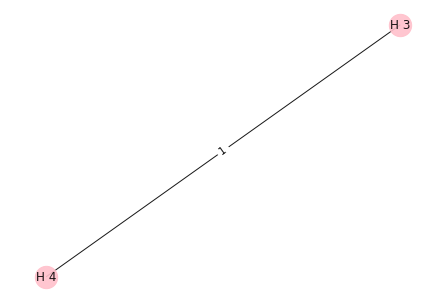

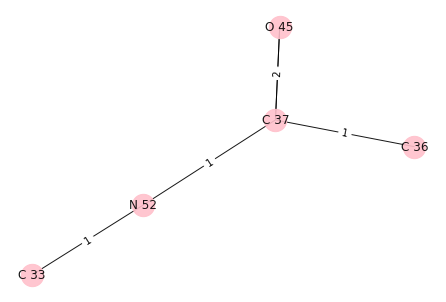

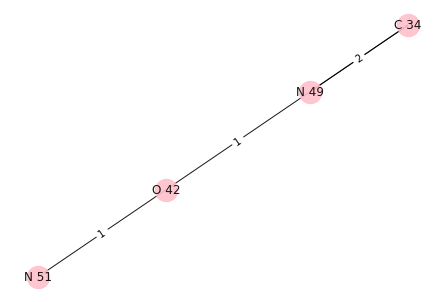

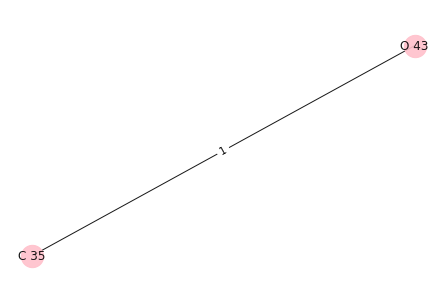

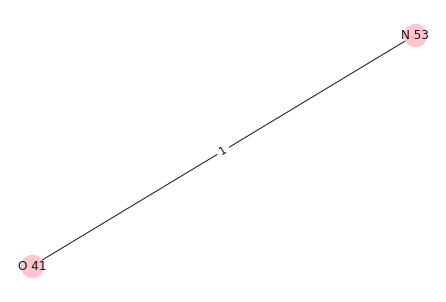

In [27]:
A_list = H_list[0:5]
B_list = C_list[0:5]
Z_list = O_list[0:5]
Y_list = N_list[0:5]

M = nx.MultiGraph()
for i,lst in enumerate([A_list, B_list, Z_list, Y_list]):
    for comp in lst:
        M.add_node(comp, data=comp)

for i in nx.nodes(M):
    i.current_valency(G)
        
new_M = generate_random_graphs_new(M, 15, 2)
for i in nx.connected_components(new_M):
    if len(i) > 1:
        plot_fig(M.subgraph(list(i)))

In [36]:
def rearrange_connected_components(G, cc, n, times):
    for i in range(times):
        comp1_idx = random.randint(0,n-1)
        comp2_idx = random.randint(0,n-1)
        comp1 = G.subgraph(list(cc[comp1_idx]))
        comp2 = G.subgraph(list(cc[comp2_idx]))
        
        attr1 = nx.get_edge_attributes(comp1, 'number')
        attr2 = nx.get_edge_attributes(comp2, 'number')
        num_rewire = 0
        
        if len(attr1) > 0 and len(attr2) > 0:
            rewire_flag = False
            attempt = 0
            # Allowing t approx 3 attempts max, in case it didn't rewire
            while (rewire_flag == False) and (attempt < 3):
                edge1_idx = random.randint(0,len(attr1)-1)
                edge1_valence = list(attr1.values())[edge1_idx]
                edge1_nodes = list(attr1.keys())[edge1_idx]

                possible_edge2_nodes = [i for i in attr2 if attr2[i]==edge1_valence]
                if len(possible_edge2_nodes) >= 1: 
                    r = random.randint(0, len(possible_edge2_nodes)-1)
                    edge2_nodes = possible_edge2_nodes[r]
                    
                    G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                    G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                    num_rewire += 1
                    rewire_flag = True
                    attempt += 1
                    for number in range(edge1_valence):
                        G.add_edge(edge1_nodes[0], edge2_nodes[0])
                        G.add_edge(edge1_nodes[1], edge2_nodes[1])
        
        if len(attr1) > 0 and len(attr2) == 0:
            max_valency = list(cc[comp2_idx])[0]._valency
            possible_edge1_nodes = [i for i in attr1 if attr1[i]<=max_valency]
            if len(possible_edge1_nodes) >= 1:
                r = random.randint(0, len(possible_edge1_nodes)-1)
                edge1_nodes = possible_edge1_nodes[r]
                valency = attr1[edge1_nodes]

                G.remove_edge(edge1_nodes[0], edge1_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge1_nodes[0], list(cc[comp2_idx])[0])

        if len(attr2) > 0 and len(attr1) == 0:
            max_valency = list(cc[comp1_idx])[0]._valency
            possible_edge2_nodes = [i for i in attr2 if attr2[i]<=max_valency]
            if len(possible_edge2_nodes) >= 1: 
                r = random.randint(0, len(possible_edge2_nodes)-1)
                edge2_nodes = possible_edge2_nodes[r]
                valency = attr2[edge2_nodes]

                G.remove_edge(edge2_nodes[0], edge2_nodes[1])
                num_rewire += 1
                for number in range(valency):
                    G.add_edge(edge2_nodes[0], list(cc[comp1_idx])[0])
    return G

In [39]:
cc = list(nx.connected_components(G))
n = len(cc)
times = n//2
print("Old connected components:")
for i in cc:
    print(i)
G_new = rearrange_connected_components(G, cc, n, times)
cc = list(nx.connected_components(G_new))
print("New connected components:")
for i in cc:
    print(i)

Old connected components:
{H 1, O 43}
{H 2, H 27}
{H 3, H 8}
{H 4, N 50, O 47}
{H 5, H 29}
{H 6, N 52}
{N 49, H 7, H 9, C 33, H 10}
{H 11, H 23}
{C 34, N 51, H 12, H 14}
{H 13}
{H 15}
{H 16, C 38}
{H 17, H 28}
{C 36, H 18}
{H 19, H 21}
{H 20}
{H 22}
{H 24}
{H 25}
{H 26}
{H 30}
{H 31}
{H 32}
{C 35}
{C 37}
{C 39}
{C 40}
{O 41}
{O 42}
{O 44}
{O 45}
{O 46}
{O 48}
{N 53}
{N 54}
{N 55}
{N 56}
New connected components:
{H 1, O 43}
{H 2, H 27}
{H 3, H 8}
{H 4, C 40}
{H 5, H 29}
{H 6, N 52}
{N 49, H 7, H 9, C 33, H 10}
{H 11, H 23}
{C 34, N 51, H 12, N 55}
{H 13}
{H 14}
{H 15}
{H 16, C 38}
{H 17, H 28}
{C 36, H 18}
{H 19, H 21}
{H 20}
{H 22}
{H 24}
{H 25}
{H 26}
{H 30}
{H 31}
{H 32}
{C 35}
{C 37}
{C 39}
{O 41}
{O 42}
{O 44}
{O 45}
{O 46}
{N 50, O 47}
{O 48}
{N 53}
{N 54}
{N 56}


In [56]:
# Simulated Annealing

def simulated_annealing(best_G, max_bonds, least_energy, bond_factor, T):
    p = random.uniform(0.0, 1.0)
    cc_initial = list(nx.connected_components(G))
    n = len(cc_initial)
    
    if p < 0.1:
        times = n//2        
        G_rand = generate_random_graphs_new(G, max_bonds, bond_factor)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    if p < 0.6:
        times = min(n//2, 2)
        G_rand = generate_random_graphs_new(G, max_bonds, bond_factor)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
    
    else:
        times = min(n//2, 1)
        G_rand = generate_random_graphs_new(G, max_bonds, bond_factor)
        G_new = rearrange_connected_components(G_rand, cc, n, times)
        new_energy = input_G(G_new)
        rand_energy = input_G(G_rand)
        
    if new_energy < least_energy and new_energy < rand_energy:
        best_G = G_new
        least_energy = new_energy
    elif rand_energy < new_energy and rand_energy < least_energy:
        best_G = G_rand
        least_energy = rand_energy
    else:
        p_decide = random.uniform(0.0,1.0)
        if p_decide < math.exp(-(new_energy - least_energy)/T):
            best_G = G_new
            least_energy = new_energy
        elif p_decide < math.exp(-(rand_energy - least_energy)/T):
            best_G = G_rand
            least_energy = rand_energy
    
    return (best_G, least_energy)

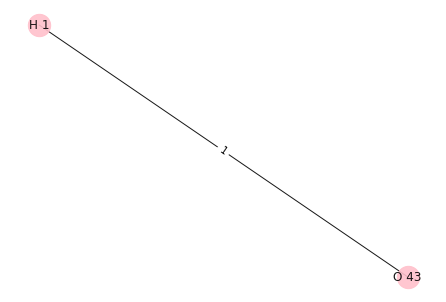

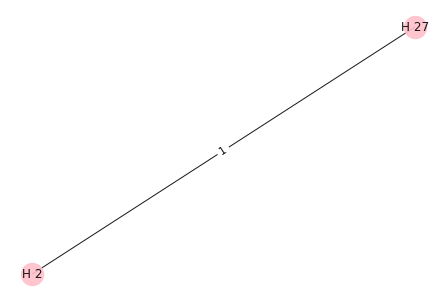

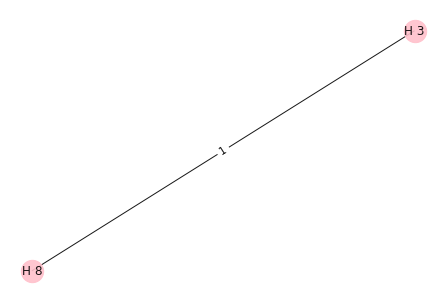

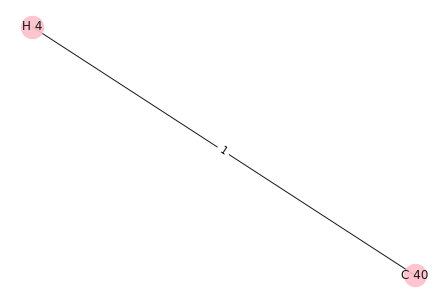

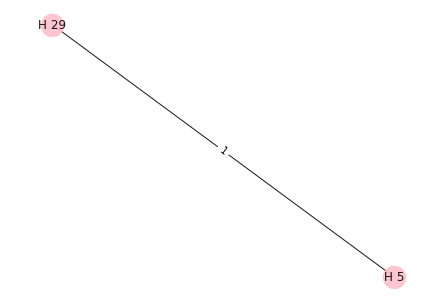

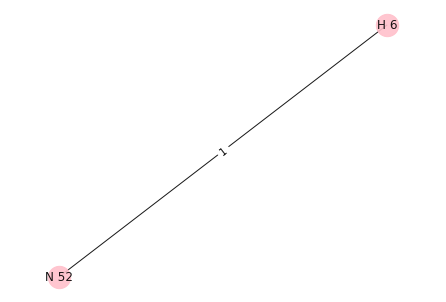

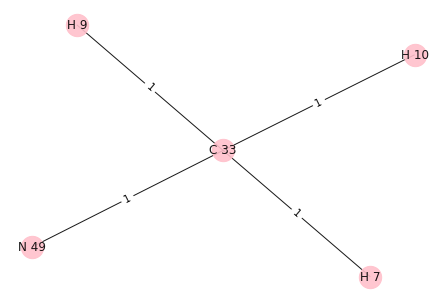

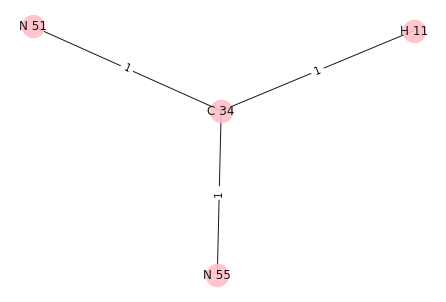

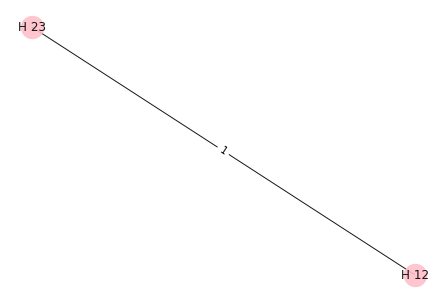

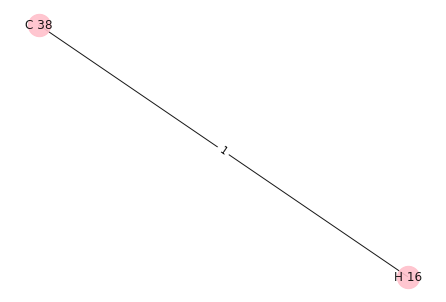

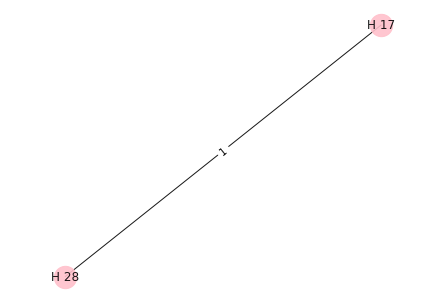

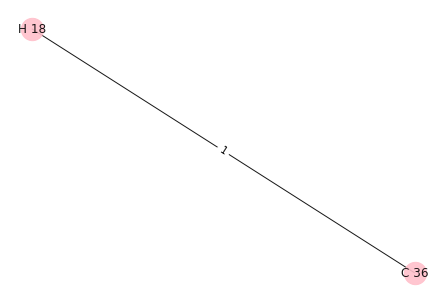

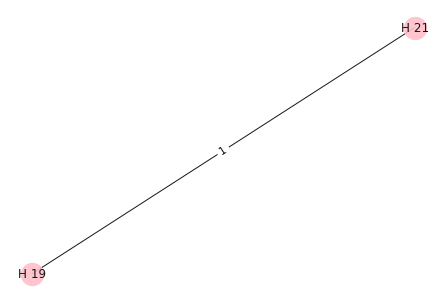

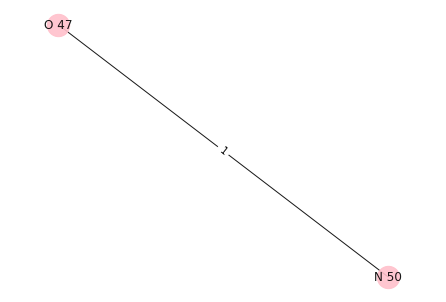

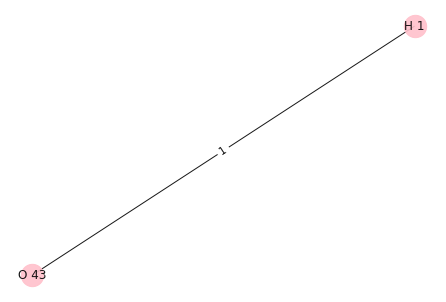

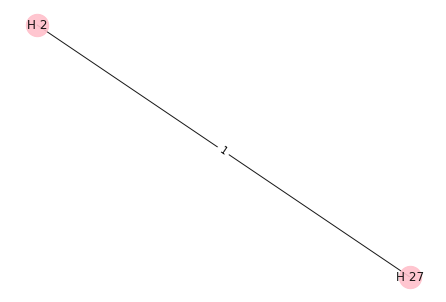

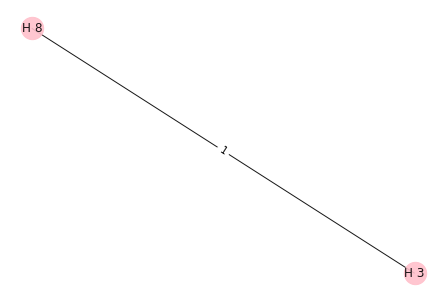

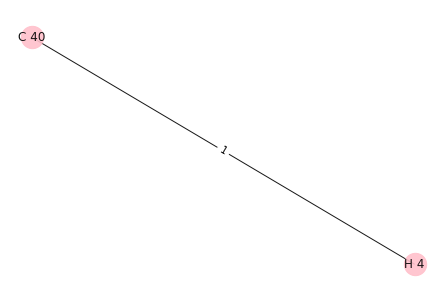

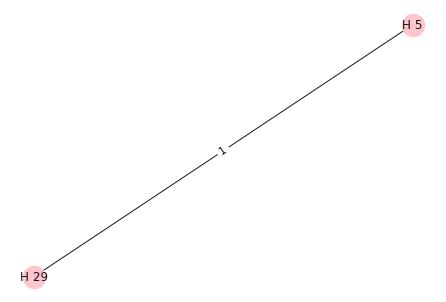

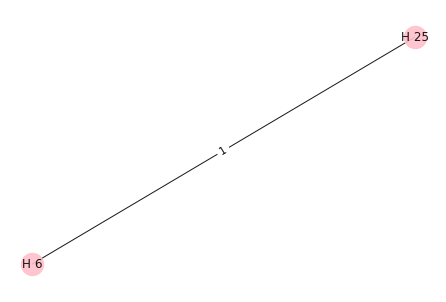

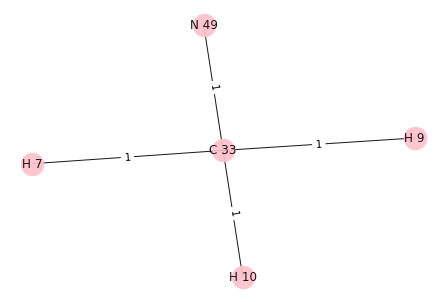

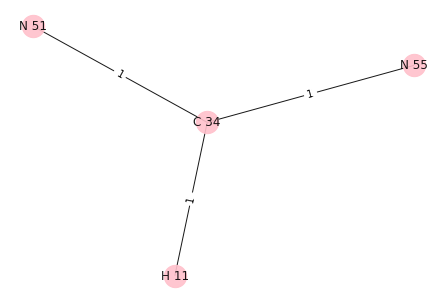

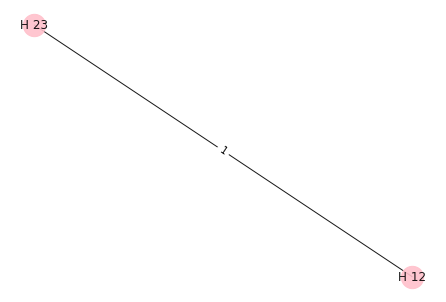

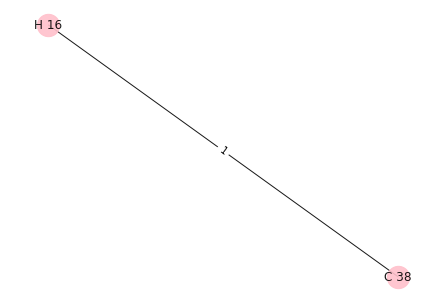

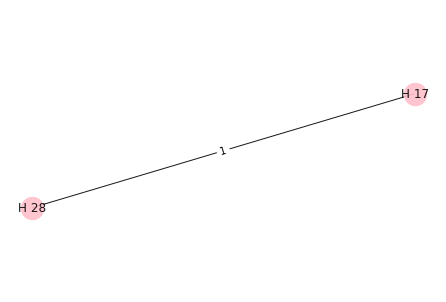

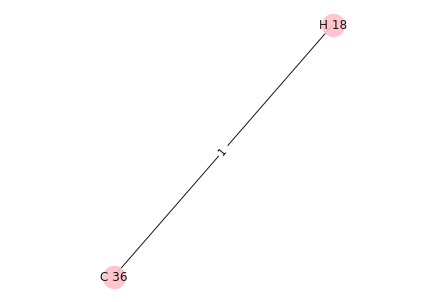

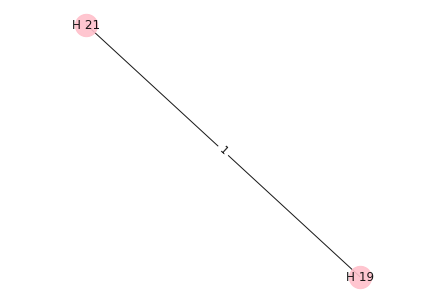

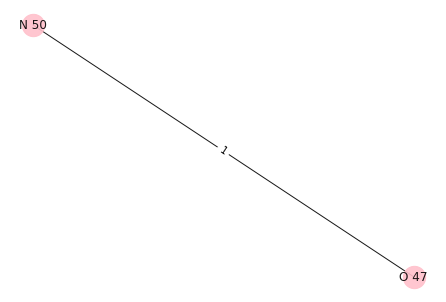

flag_end: 2
O 43 Previous Valency: 1
O 43 Current valency: 0
N 52 Previous Valency: 1
N 52 Current valency: 2
flag_end: 2
O 45 Previous Valency: 2
O 45 Current valency: 1
N 50 Previous Valency: 2
N 50 Current valency: 1
flag_end: 0
C 34 Previous Valency: 1
C 34 Current valency: 0
N 49 Previous Valency: 2
N 49 Current valency: 1
flag_end: 1
H 31 Previous Valency: 1
H 31 Current valency: 1
N 53 Previous Valency: 3
N 53 Current valency: 3
flag_end: 2
H 14 Previous Valency: 1
H 14 Current valency: 0
H 22 Previous Valency: 1
H 22 Current valency: 0
flag_end: 1
H 24 Previous Valency: 1
H 24 Current valency: 1
H 32 Previous Valency: 1
H 32 Current valency: 1
flag_end: 2
H 26 Previous Valency: 1
H 26 Current valency: 0
N 50 Previous Valency: 1
N 50 Current valency: 0
flag_end: 0
H 31 Previous Valency: 1
H 31 Current valency: 0
O 41 Previous Valency: 2
O 41 Current valency: 1
flag_end: 2
C 39 Previous Valency: 4
C 39 Current valency: 3
O 46 Previous Valency: 2
O 46 Current valency: 1
flag_end: 

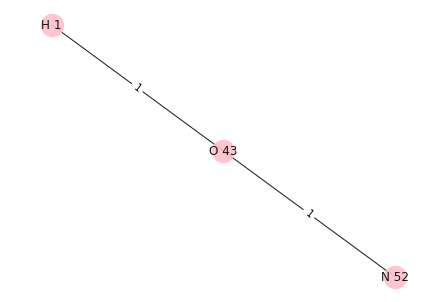

Enter G value of [H 1, N 52, O 43]: -215860.156


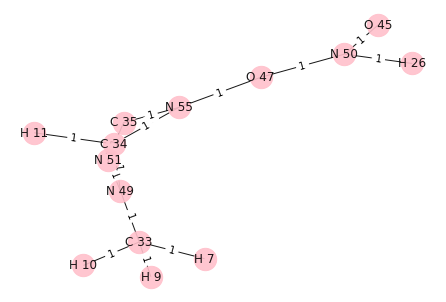

Enter G value of [N 51, C 34, H 11, H 26, N 49, O 47, H 7, N 55, C 35, H 9, C 33, N 50, H 10, O 45]: 1e16


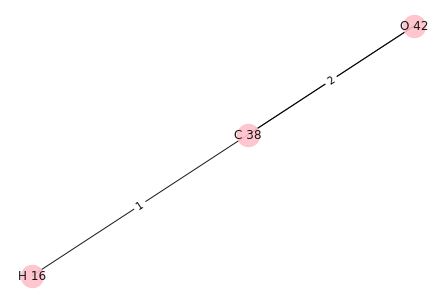

Enter G value of [H 16, O 42, C 38]: -563584.8


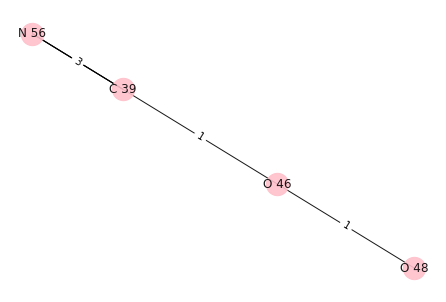

Enter G value of [O 46, C 39, N 56, O 48]: 1e15


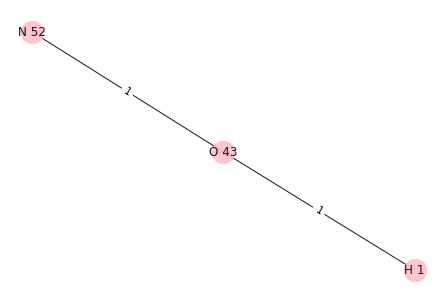

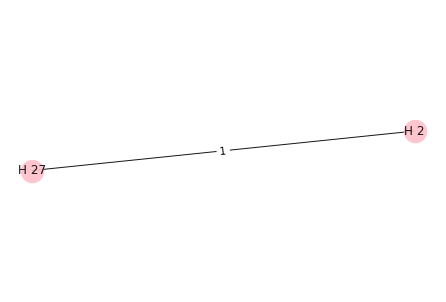

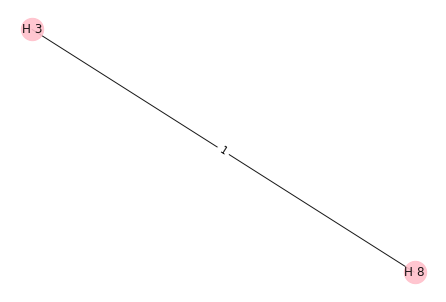

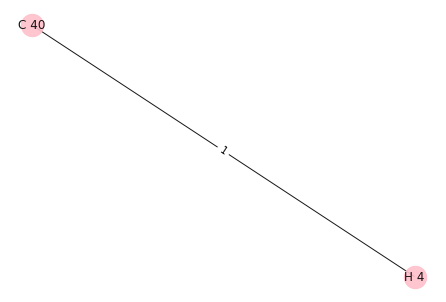

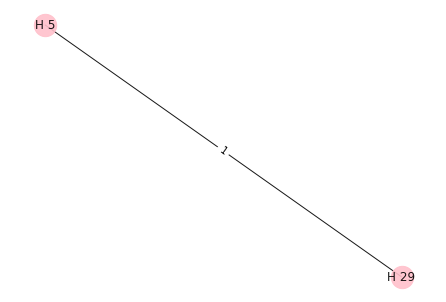

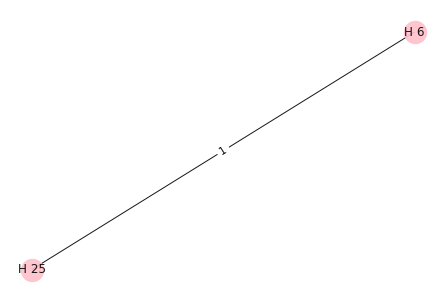

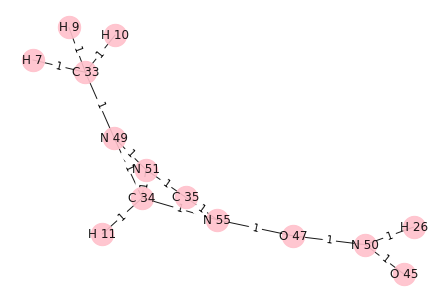

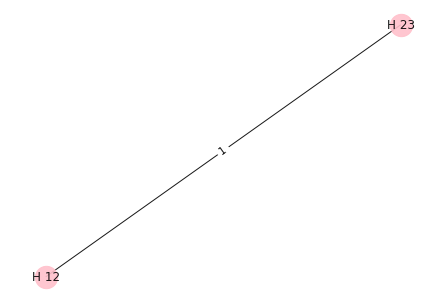

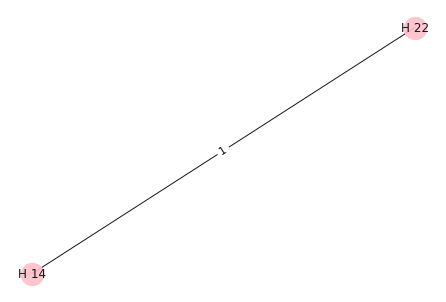

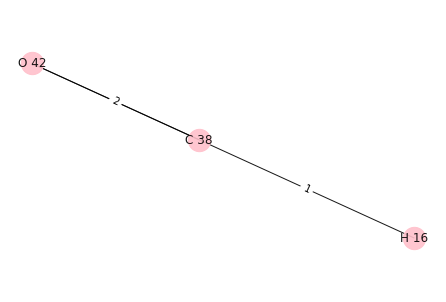

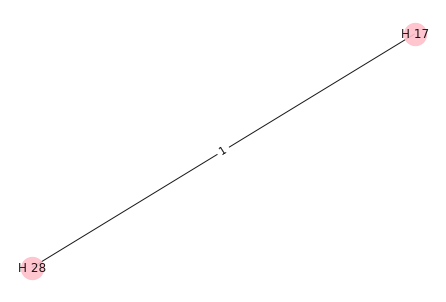

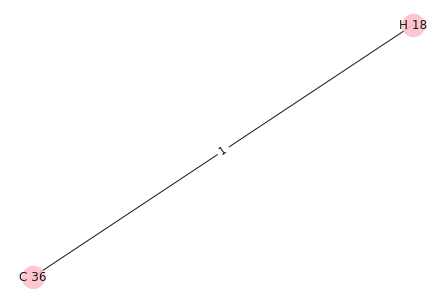

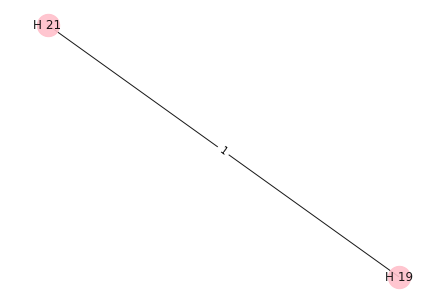

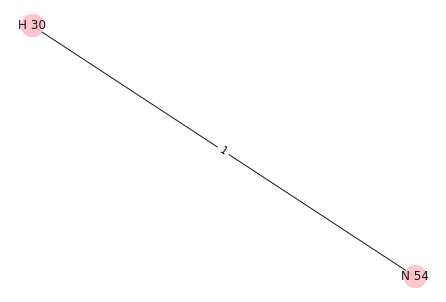

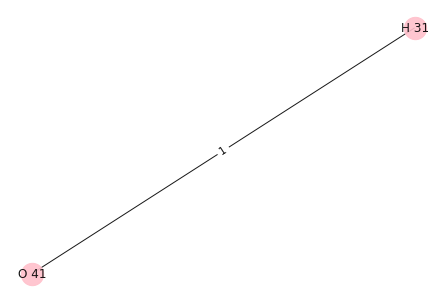

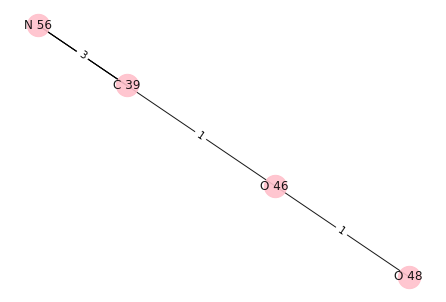

flag_end: 2
C 37 Previous Valency: 4
C 37 Current valency: 3
O 45 Previous Valency: 1
O 45 Current valency: 0
flag_end: 2
H 24 Previous Valency: 1
H 24 Current valency: 0
O 41 Previous Valency: 1
O 41 Current valency: 0
flag_end: 2
C 38 Previous Valency: 1
C 38 Current valency: 0
N 54 Previous Valency: 2
N 54 Current valency: 1
flag_end: 2
C 40 Previous Valency: 3
C 40 Current valency: 1
N 52 Previous Valency: 2
N 52 Current valency: 0


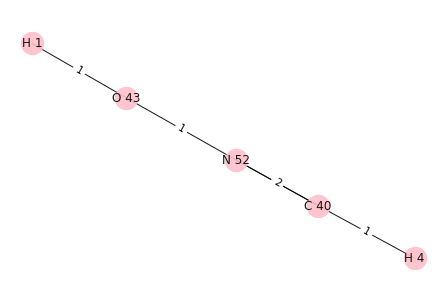

Enter G value of [C 40, H 4, H 1, N 52, O 43]: -170469.89650869687


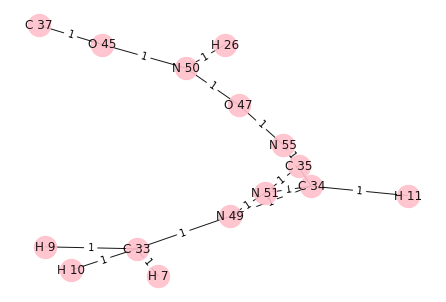

Enter G value of [C 37, N 51, C 34, H 11, H 26, N 49, O 47, H 7, N 55, C 35, H 9, C 33, N 50, H 10, O 45]: 1e16


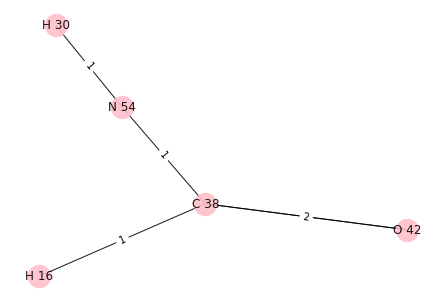

Enter G value of [C 38, H 16, O 42, N 54, H 30]: -374507.5468211238


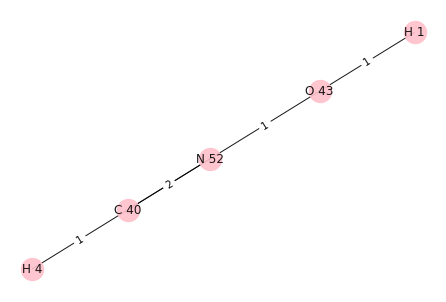

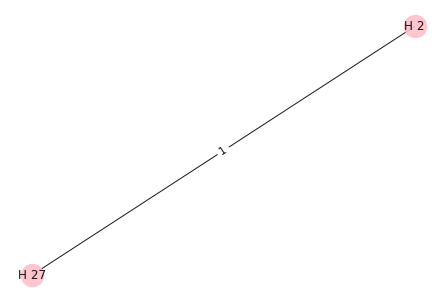

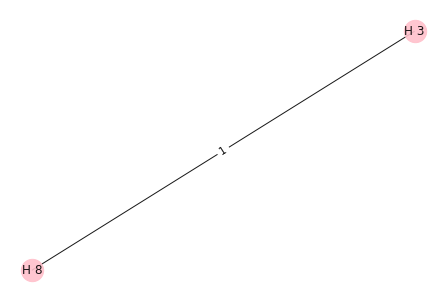

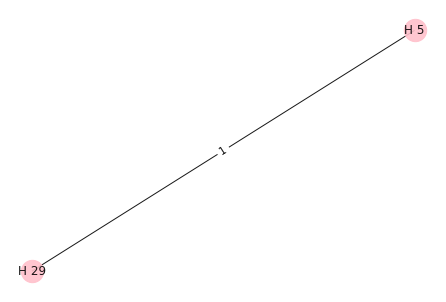

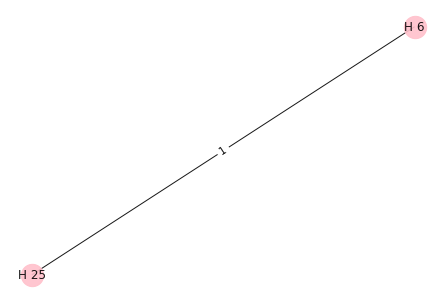

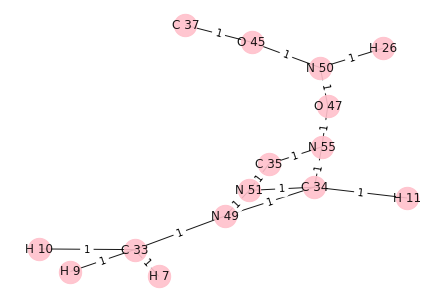

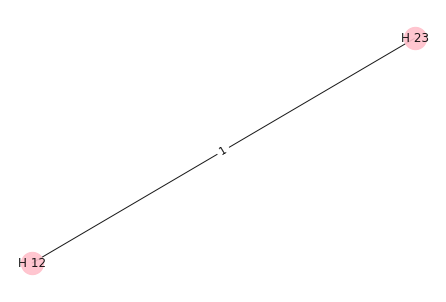

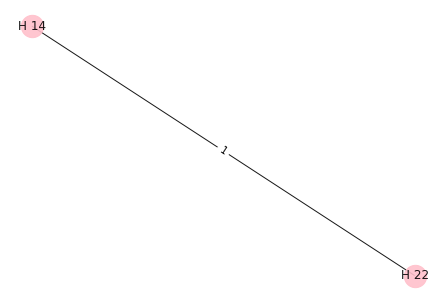

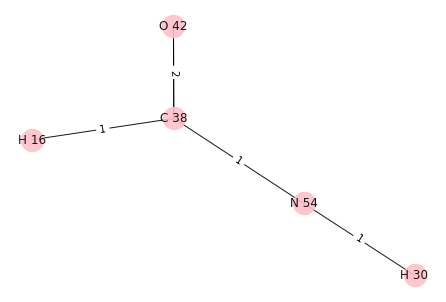

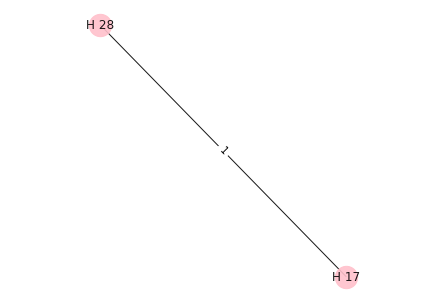

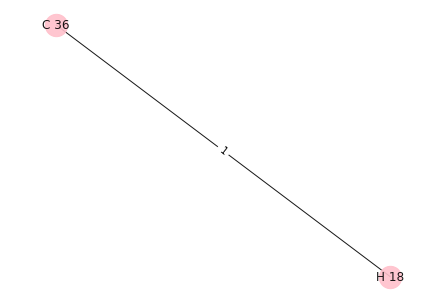

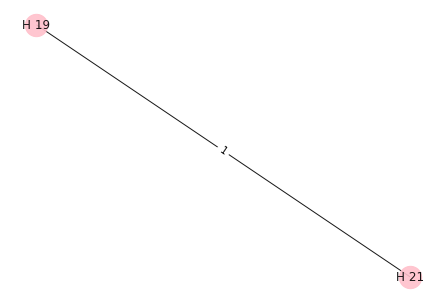

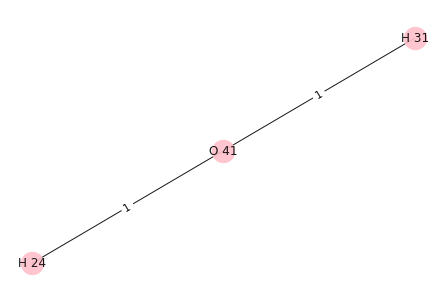

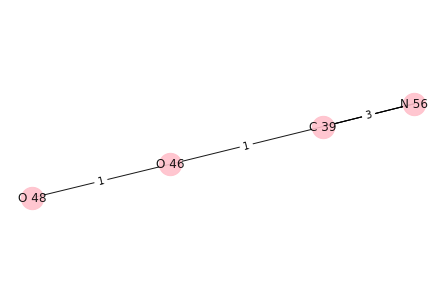

flag_end: 2
C 36 Previous Valency: 3
C 36 Current valency: 1
C 37 Previous Valency: 3
C 37 Current valency: 1
flag_end: 2
H 20 Previous Valency: 1
H 20 Current valency: 0
O 48 Previous Valency: 1
O 48 Current valency: 0


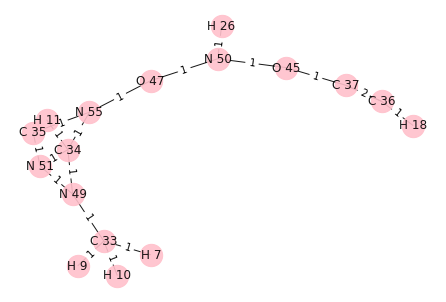

Enter G value of [C 37, C 36, N 51, C 34, H 11, H 26, N 49, O 47, H 7, N 55, H 18, C 35, H 9, C 33, N 50, H 10, O 45]: 1e16


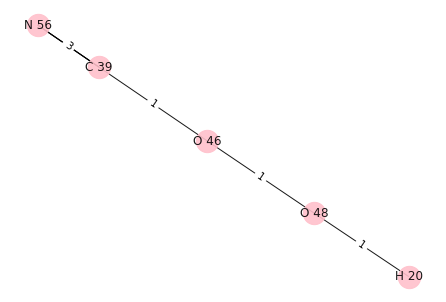

In [ ]:
cycles = 100
T = 1
for i in range(cycles):
    energy = input_G(G)
    G, energy = simulated_annealing(G, maximum_edges, energy, i, T)
    T = T*0.995

In [ ]:
for i in G.nodes:
    i.current_valency(G)

In [ ]:
V = simulated_annealing(G)

In [ ]:
for node in G.nodes:
    if node._name == "H 20": main_node = node
    print(node._name, node._valency, nx.degree(G, node))
    
cc = nx.connected_components(G)
for i in cc:
    if main_node in i:
        for j in nx.neighbors(G, main_node):
            print(j)
        plot_fig(G.subgraph(list(i)))

In [ ]:
a = nx.connected_components(G)
a = list(a)
print(a)
N = G.subgraph(list(a[9]))
input_G(N) 

In [ ]:
# Yay! input_G works. But the order of checking nodes is slight'a screwed up. Will have to check

In [ ]:
# NOT NEEDED 

# Loop through the atoms and components
# The following are the conditions used:
#   - Choice 1: Loop through the atoms
#   - Choice 2: Loop through the compounds
#   - Choice 3: Loop through both

# n_a = len(atoms)
# n_c = len(compounds)

# a = 0
# c = 0

# choice = r.randint(0,3)

# if choice == 0:
    # a = 2
    # i = r.randint(0,n_a-1)
    # j = r.randint(0,n_a-1)
    # print('Choosing two atoms : %s and %s'%(atoms[i],atoms[j]))
    # Gi_1 = float(input('Enter G value of %s: '%atoms[i]))
    # Gi_2 = float(input('Enter G value of %s: '%atoms[j]))
    
# elif choice == 1:
    # c = 2
    # i = r.randint(0,n_c-1)
    # j = r.randint(0,n_c-1)
    # print('Choosing two compounds: %s and %s'%(compounds[i],compounds[j]))
    # Gi_1 = float(input('Enter G value of %s: '%compounds[i]))
    # Gi_2 = float(input('Enter G value of %s: '%compounds[j]))

# elif choice == 2:
    # a = 1
    # c = 1
    # i = r.randint(0,n_a-1)
    # j = r.randint(0,n_c-1)
    # print('Choosing an atom and a compound: %s and %s'%(atoms[i],compounds[j]))
    # Gi_1 = float(input('Enter G value of %s: '%atoms[i]))
    # Gi_2 = float(input('Enter G value of %s: '%compounds[j]))

In [ ]:
def generate_random_graphs_old(G,bonds):
    # Get the list of all nodes in the network
    nodes = list(nx.nodes(G))
    # Get connected components
    connected_components = nx.connected_components(G)
    # Get the adjacency matrix, but we won't use it here
    A = nx.adjacency_matrix(G)
    # Get the number of extra edges to be formed
    # The exponential code has been added above
    bonds -= nx.number_of_edges(G)
    
    # While the number of bonds existing < number of binds needed to be formed
    while nx.number_of_edges(G) < bonds:
        # Get a random row index
        # So, here the row index would represent an atom
        # Remember 1-32 H, 33-41 C, ...
        row = r.randint(1,55)
        # Gets the current valency of the node
        cur_val1 = (nodes[row])._valency
        
        # Until a row (i.e.) a node with >1 valence if found, keep looping
        while not(cur_val1 > 0):
            row = r.randint(1,55)
            cur_val1 = nodes[row]._valency
        # Once found, get the second node, the column in the network
        else:
            col = r.randint(0, row-1)
            cur_val2 = nodes[col]._valency
            # Until a column (i.e.) a node with >1 valence if found, keep looping
            while not(cur_val2 > 0):
                col = r.randint(0, row-1)
                cur_val2 = nodes[col]._valency
                if cur_val2 > 0:
                    # If feasible nodes are found, add edge between them
                    G.add_edge(nodes[row], nodes[col])
            # If feasible edges are found before all this looping stuf, add edge
            else:
                G.add_edge(nodes[row], nodes[col])
        
        # Update the valency of all the nodes once a bond is formed
        for i in list(nx.nodes(G)): 
            i.current_valency(G)
    
    # Finally return the graph which was found with great efforts :D
    return G

In [ ]:
import networkx.algorithms.isomorphism as iso
nm = iso.categorical_node_match('size', 1)
nm = iso.categorical_node_match(['color', 'size'], ['red', 2])
print(nm)

In [ ]:
a = [1,2,3,4]
b = [3,4,1,2]
b = b.sort()
a = a.sort()
if b == a:
    print(True)
else:
    print(False)

In [ ]:
a = nx.connected_components(V)
a = list(a)
for i in range(len(a)):
    if len(a[i])==10:
        sub = V.subgraph(list(a[i]))
        plot_fig(sub)